In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax 
import matplotlib.pyplot as plt

### Problema: Equação de Poisson com condição de contorno de Dirichlet

O problema proposto é dado por:

$$
- \bigtriangleup u = \pi^2 \sin(\pi x), \hspace{0.5cm} x \in [-1, 1]
$$
onde as condições de contorno são dadas por $u(-1) = u(1) = 0$.


A solução exata do problema é $u(x) = \sin(\pi x)$

In [2]:
# DECLARAÇÃO DA ARQUITETURA
key, init_key = jr.split(jr.PRNGKey(123))
MODEL = eqx.nn.MLP(
    in_size = 'scalar',
    out_size = 'scalar',
    width_size = 10,
    depth = 4,
    activation = jax.nn.sigmoid,
    key = init_key,
)

# DEFINIÇÃO DA EQUAÇÃO RESIDUAL
def f(x): 
    return jnp.pi**2 * jnp.sin(jnp.pi * x)

def residuo(model, x):
    u_xx = jax.grad(jax.grad(model))(x)

    return u_xx + f(x)

# FUNÇÃO DE PERDA
key, sampling_key = jr.split(key)
pontos_interiores = jr.uniform(sampling_key, (1000, ), minval = -1.0 + 0.001, maxval = 1.0 - 0.001)

def loss_fn(model):

    # PERDA DA EQUAÇÃO RESIDUAL
    out_res = jax.vmap(residuo, in_axes = (None, 0))(model, pontos_interiores)
    loss_res = jnp.mean(jnp.square(out_res))

    # PERDA PARA OS VALORES DE CONTORNO
    out_cont1 = model(-1.0)
    out_cont2 = model(1.0)
    loss_cont1 = jnp.mean(jnp.square(out_cont1))
    loss_cont2 = jnp.mean(jnp.square(out_cont2))

    # PERDA TOTAL
    loss = loss_res + loss_cont1 + loss_cont2
    return loss

# TREINAMENTO

OPTIMIZER = optax.adam(1e-3)
OPT_STATE = OPTIMIZER.init(eqx.filter(MODEL, eqx.is_array))

@eqx.filter_jit
def trainning(model, state):

    loss, grad = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = OPTIMIZER.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

LOSS_HISTORY = []
for ep in range(10000):

    MODEL, OPT_STATE, LOSS = trainning(MODEL, OPT_STATE)
    LOSS_HISTORY.append(LOSS)   
    if ep % 1000 == 0:
        print(f'Epochs: {ep} Loss: {LOSS}')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Epochs: 0 Loss: 47.869075775146484
Epochs: 1000 Loss: 15.78287410736084
Epochs: 2000 Loss: 13.327747344970703
Epochs: 3000 Loss: 6.053254127502441
Epochs: 4000 Loss: 1.3866850137710571
Epochs: 5000 Loss: 0.00917536299675703
Epochs: 6000 Loss: 0.004523370880633593
Epochs: 7000 Loss: 0.0025562173686921597
Epochs: 8000 Loss: 0.0015057867858558893
Epochs: 9000 Loss: 0.0008465719292871654


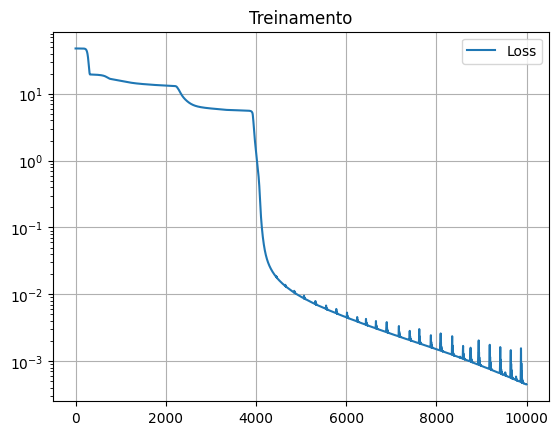

In [3]:
plt.plot(LOSS_HISTORY, label = 'Loss')
plt.title('Treinamento')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

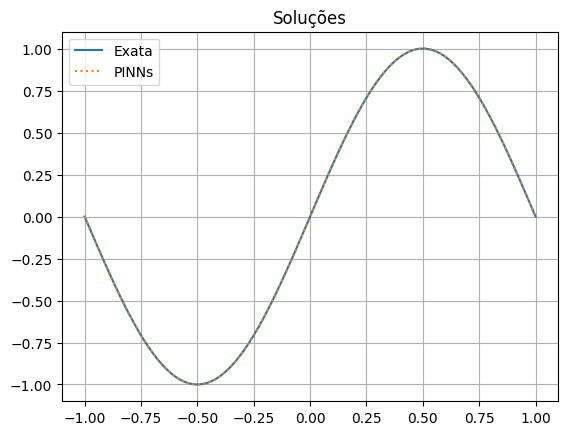

In [9]:
X = jnp.linspace(-1, 1, 100)
EXATA = jnp.sin(jnp.pi * X)
PRED = jax.vmap(MODEL)(X)

plt.plot(X, EXATA, label = 'Exata')
plt.plot(X, PRED, label = 'PINNs', linestyle = 'dotted')
plt.title('Soluções')
plt.grid()
plt.legend()
plt.show()